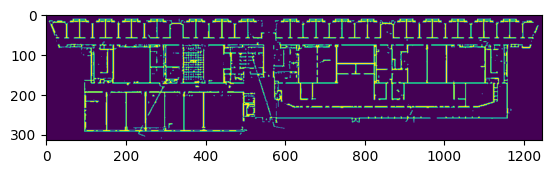

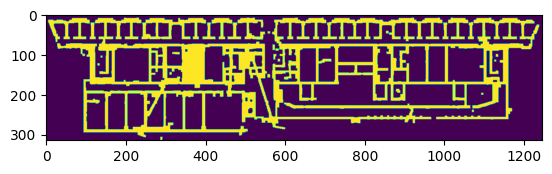

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image, grayscale, Gaussian blur, Otsus threshold
image = cv2.imread('original_dfp/DeepFloorplan-master/output/reassembled/reassembled_E2_2.png')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise and improve thresholding
blur = cv2.GaussianBlur(gray, (3,3), 0)

# Apply Otsu's thresholding to convert grayscale to a binary image
# This will make walls white (255) and background black (0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the binary image: walls become white (255), background becomes black (0)
inverted_thresh = cv2.bitwise_not(thresh)

# Save the inverted image to a file
cv2.imwrite('inverted_image.png', inverted_thresh)

plt.figure()
plt.imshow(inverted_thresh)

img = inverted_thresh

kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)
img = cv2.dilate(img,kernel,iterations = 1)

plt.figure()
plt.imshow(img)

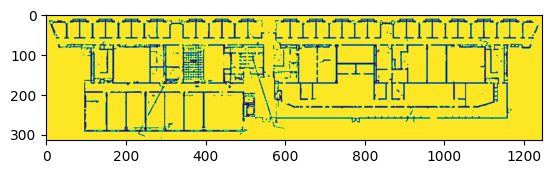

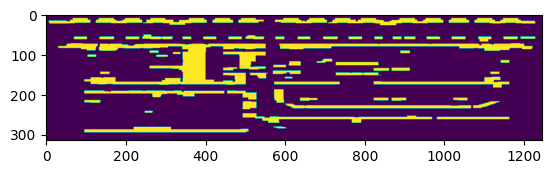

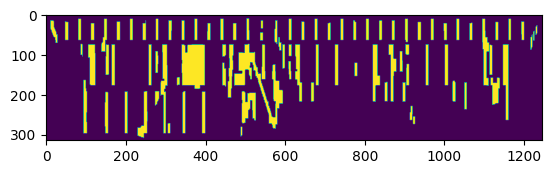

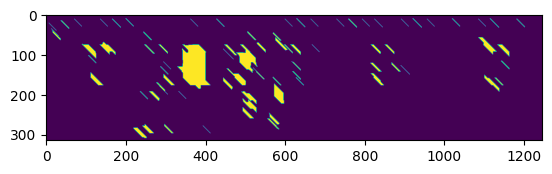

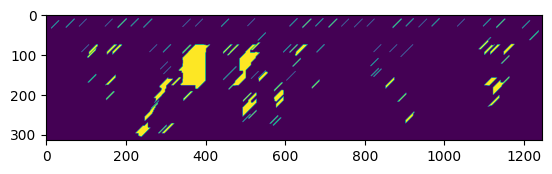

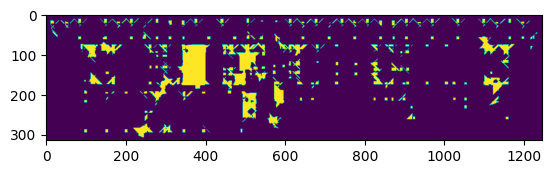

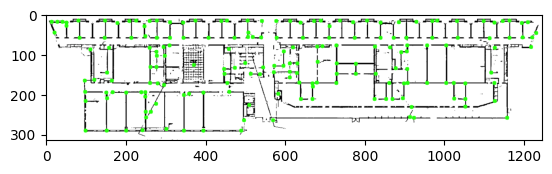

In [2]:
# Find horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,1))
horizontal = cv2.morphologyEx(img, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

# Find vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
vertical = cv2.morphologyEx(img, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

# Custom diagonal kernels
size = 10  # This size can be adjusted depending on your specific requirements
diag1_kernel = np.eye(size, dtype=np.uint8)
diag2_kernel = np.fliplr(diag1_kernel)

# Find diagonal lines
diagonal1 = cv2.morphologyEx(img, cv2.MORPH_OPEN, diag1_kernel, iterations=2)
diagonal2 = cv2.morphologyEx(img, cv2.MORPH_OPEN, diag2_kernel, iterations=2)


# Find joints
# Find intersections between horizontal and vertical lines
hv_intersections = cv2.bitwise_and(horizontal, vertical)

# Find intersections between horizontal and both diagonals
hd1_intersections = cv2.bitwise_and(horizontal, diagonal1)
hd2_intersections = cv2.bitwise_and(horizontal, diagonal2)

# Find intersections between vertical and both diagonals
vd1_intersections = cv2.bitwise_and(vertical, diagonal1)
vd2_intersections = cv2.bitwise_and(vertical, diagonal2)

# Find intersections between both diagonals
dd_intersections = cv2.bitwise_and(diagonal1, diagonal2)

# Combine all intersections to find all joints
joints = cv2.bitwise_or(hv_intersections, hd1_intersections)
joints = cv2.bitwise_or(joints, hd2_intersections)
joints = cv2.bitwise_or(joints, vd1_intersections)
joints = cv2.bitwise_or(joints, vd2_intersections)
joints = cv2.bitwise_or(joints, dd_intersections)

# Find centroid of the joints
cnts, _ = cv2.findContours(joints, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
centroids = []

for c in cnts:
    # Calculate centroid and draw center point
    M = cv2.moments(c)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx, cy))
        cv2.circle(image, (cx, cy), 5, (36,255,12), -1)
    else:
        pass
plt.figure()
plt.imshow(thresh)

plt.figure()
plt.imshow(horizontal)

plt.figure()
plt.imshow(vertical)

plt.figure()
plt.imshow(diagonal1)

plt.figure()
plt.imshow(diagonal2)

plt.figure()
plt.imshow(joints)

plt.figure()
plt.imshow(image)

(array([[[   0,    0]],

       [[   0,  314]],

       [[ 254,  314]],

       [[ 255,  313]],

       [[ 256,  314]],

       [[ 260,  314]],

       [[ 261,  313]],

       [[ 262,  314]],

       [[ 317,  314]],

       [[ 318,  313]],

       [[ 319,  314]],

       [[1245,  314]],

       [[1245,    0]]], dtype=int32), array([[[288, 309]],

       [[289, 308]],

       [[290, 308]],

       [[291, 309]],

       [[289, 311]],

       [[288, 310]]], dtype=int32), array([[[247, 305]],

       [[248, 304]],

       [[249, 305]],

       [[248, 306]]], dtype=int32), array([[[244, 304]],

       [[245, 303]],

       [[247, 303]],

       [[248, 304]],

       [[247, 305]],

       [[245, 305]]], dtype=int32), array([[[486, 301]],

       [[487, 300]],

       [[488, 301]],

       [[487, 302]]], dtype=int32), array([[[236, 301]],

       [[237, 300]],

       [[239, 300]],

       [[240, 301]],

       [[242, 301]],

       [[243, 302]],

       [[244, 302]],

       [[245, 303]],

 

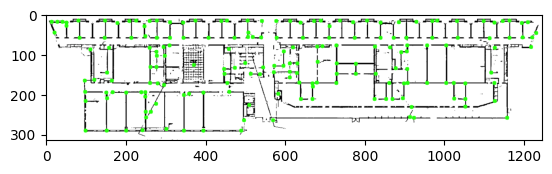

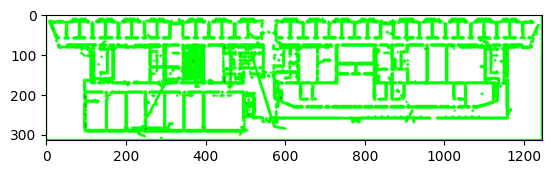

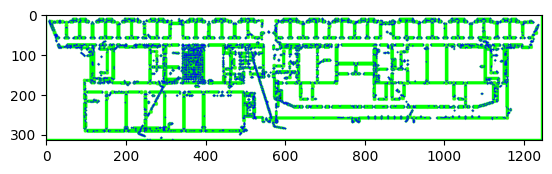

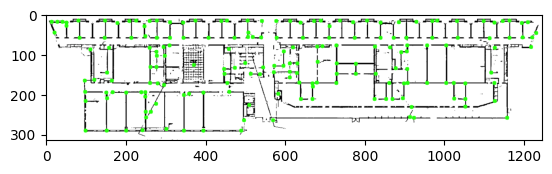

In [3]:
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours)
# Draw contours on the original image
plt.figure()
plt.imshow(image)
im = image.copy()
cv2.drawContours(im, contours, -1, (0,255,0), 3)
plt.figure()
plt.imshow(im)

# Overlay each point in contours onto the image
for contour in contours:
    for point in contour:
        cv2.circle(im, (point[0][0], point[0][1]), radius=1, color=(0, 0, 255), thickness=-1)
plt.figure()
plt.imshow(im)
plt.figure()
plt.imshow(image)

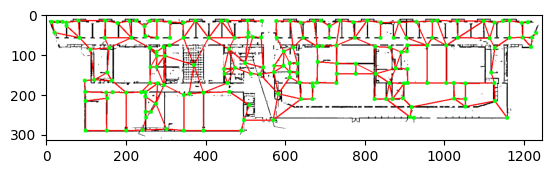

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Load image
image = cv2.imread('SkeletonTrace/reassembled_E2_2.png')  # Adjusted to the uploaded image path

# Function to parse SVG file and extract lines
def parse_svg(svg_filename):
    tree = ET.parse(svg_filename)
    root = tree.getroot()
    svg_lines = []
    for line in root.findall('.//{http://www.w3.org/2000/svg}line'):
        x1, y1, x2, y2 = (int(line.get('x1')), int(line.get('y1')),
                          int(line.get('x2')), int(line.get('y2')))
        svg_lines.append(((x1, y1), (x2, y2)))
    return svg_lines

# Function to find the closest centroid to a given point
def find_closest_centroid(point, centroids):
    min_distance = float('inf')
    closest_centroid = None
    for centroid in centroids:
        dist = np.linalg.norm(np.array(point) - np.array(centroid))
        if dist < min_distance:
            min_distance = dist
            closest_centroid = centroid
    return closest_centroid, min_distance

# Function to draw lines that are similar to the lines from the SVG
def draw_similar_lines(image, centroids, svg_lines, max_distance=60):  # Increased max_distance
    line_image = image.copy()

    # Iterate over SVG lines
    for svg_line in svg_lines:
        start_svg, end_svg = svg_line
        # Find the closest centroids to the SVG line endpoints
        start_centroid, dist_start = find_closest_centroid(start_svg, centroids)
        end_centroid, dist_end = find_closest_centroid(end_svg, centroids)
        
        # Check if the closest centroids are within a certain distance to the SVG line endpoints
        if dist_start < max_distance and dist_end < max_distance:
            # Draw the line between these centroids
            cv2.line(line_image, start_centroid, end_centroid, (0, 0, 255), 2)
    
    # After drawing the lines, draw the centroids on top
    for (x, y) in centroids:
        cv2.circle(line_image, (x, y), 5, (0, 255, 0), -1)

    return line_image



# Make sure to replace the placeholder for centroids with the actual data
# Also, make sure that the path to the SVG file is correct
svg_filename = 'SkeletonTrace/line_segments.svg'  # Replace with the actual SVG file path
svg_lines = parse_svg(svg_filename)

# Check if centroids and SVG lines are loaded correctly
if not centroids:
    raise ValueError("Centroids are not defined or empty.")
if not svg_lines:
    raise ValueError("No SVG lines were parsed from the file.")

# Draw lines on the image based on the SVG
vectorized_image = draw_similar_lines(image, centroids, svg_lines)

# Display the vectorized image
plt.imshow(cv2.cvtColor(vectorized_image, cv2.COLOR_BGR2RGB))
plt.show()


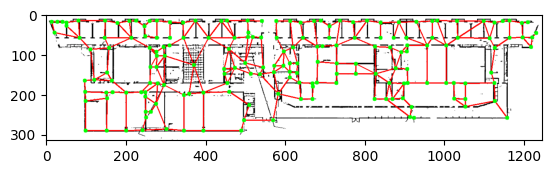

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Load image
image = cv2.imread('SkeletonTrace/reassembled_E2_2.png')  # Adjusted to the uploaded image path

# Function to parse SVG file and extract lines
def parse_svg(svg_filename):
    tree = ET.parse(svg_filename)
    root = tree.getroot()
    svg_lines = []
    for line in root.findall('.//{http://www.w3.org/2000/svg}line'):
        x1, y1, x2, y2 = (int(line.get('x1')), int(line.get('y1')),
                          int(line.get('x2')), int(line.get('y2')))
        svg_lines.append(((x1, y1), (x2, y2)))
    return svg_lines

# Function to find the closest centroid to a given point
def find_closest_centroid(point, centroids):
    min_distance = float('inf')
    closest_centroid = None
    for centroid in centroids:
        dist = np.linalg.norm(np.array(point) - np.array(centroid))
        if dist < min_distance:
            min_distance = dist
            closest_centroid = centroid
    return closest_centroid, min_distance

# Function to draw lines that are similar to the lines from the SVG
def draw_similar_lines(image, centroids, svg_lines, max_distance=50):
    line_image = image.copy()

    # Iterate over SVG lines
    for svg_line in svg_lines:
        start_svg, end_svg = svg_line
        # Find the closest centroids to the SVG line endpoints
        start_centroid, dist_start = find_closest_centroid(start_svg, centroids)
        end_centroid, dist_end = find_closest_centroid(end_svg, centroids)
        
        # Check if the closest centroids are within a certain distance to the SVG line endpoints
        if dist_start < max_distance and dist_end < max_distance:
            # Draw the line between these centroids
            cv2.line(line_image, start_centroid, end_centroid, (0, 0, 255), 2)
    
    # After drawing the lines, draw the centroids on top
    for (x, y) in centroids:
        cv2.circle(line_image, (x, y), 5, (0, 255, 0), -1)

    return line_image

# Load image
image_path = 'SkeletonTrace/reassembled_E2_2.png'  # replace with your actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image at path {image_path} could not be read.")

# Load centroids and SVG lines
svg_filename = 'SkeletonTrace/line_segments.svg'  # Replace with your actual SVG file path
svg_lines = parse_svg(svg_filename)

# Check if centroids and SVG lines are loaded correctly
if not centroids:
    raise ValueError("Centroids are not defined or empty.")
if not svg_lines:
    raise ValueError("No SVG lines were parsed from the file.")

# Draw lines on the image based on the SVG, with centroids drawn on top
vectorized_image = draw_similar_lines(image, centroids, svg_lines)

# Display the vectorized image with centroids marked
plt.imshow(cv2.cvtColor(vectorized_image, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re
import random

# Load image
image_path = 'SkeletonTrace/reassembled_E2_2.png'  # replace with your actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image at path {image_path} could not be read.")

# Function to parse SVG file and extract line elements
def parse_svg(svg_filename):
    tree = ET.parse(svg_filename)
    root = tree.getroot()
    svg_elements = []
    for element in root.findall('.//{http://www.w3.org/2000/svg}line'):
        x1, y1, x2, y2 = (int(element.get('x1')), int(element.get('y1')),
                          int(element.get('x2')), int(element.get('y2')))
        svg_elements.append(((x1, y1), (x2, y2)))
    return svg_elements

# Function to parse path 'd' attributes and extract line segments
def parse_path_d_attribute(d):
    # Split path data into commands and coordinates
    commands = re.split(r'([ML])', d)[1:]  # Omit the empty split at the start
    path_commands = zip(commands[0::2], commands[1::2])  # Pair commands with their coordinates

    # Convert string coordinates into tuples of integers
    lines = []
    last_pos = None
    for command, coord_string in path_commands:
        coords = [int(n) for n in re.findall(r'-?\d+', coord_string)]
        coord_pairs = list(zip(coords[0::2], coords[1::2]))

        if command == 'M':  # moveto sets the starting point
            last_pos = coord_pairs[0]
        elif command == 'L':  # lineto draws a line from the last position
            for pos in coord_pairs:
                lines.append((last_pos, pos))
                last_pos = pos
    return lines

# Function to read SVG content from a file
def get_svg_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to draw lines and paths on the image based on the SVG data
def draw_svg_elements(image, svg_elements, thickness=5):
    line_image = image.copy()

    # Iterate over SVG elements and draw them on the image
    for element in svg_elements:
        start_point, end_point = element
        # Generate a random color for each line
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(line_image, start_point, end_point, color, thickness)

    return line_image

# Load SVG content and extract elements
svg_filename = 'SkeletonTrace/line_segments.svg'  # replace with your actual SVG file path
svg_content = get_svg_content(svg_filename)
svg_lines = parse_svg(svg_filename)

# Process the path data to extract lines
svg_path_lines = []
for path_data in svg_paths:
    svg_path_lines.extend(parse_path_d_attribute(path_data))

# Combine line elements and path data into a single list
svg_elements = svg_lines + svg_path_lines

# Draw SVG elements on the image
vectorized_image = draw_svg_elements(image, svg_elements)

# Display the vectorized image with SVG elements drawn
plt.imshow(cv2.cvtColor(vectorized_image, cv2.COLOR_BGR2RGB))
plt.show()


TypeError: expected string or bytes-like object, got 'tuple'

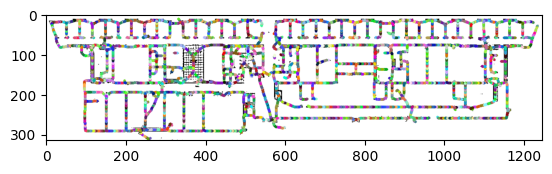

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re
import random
from sklearn.cluster import DBSCAN

# Load image
image_path = 'SkeletonTrace/reassembled_E2_2.png'  # replace with your actual image path
image = cv2.imread(image_path)
if image is None:
    raise ValueError(f"Image at path {image_path} could not be read.")

# Function to parse SVG file and extract line elements
def parse_svg(svg_filename):
    tree = ET.parse(svg_filename)
    root = tree.getroot()
    svg_elements = []
    for element in root.findall('.//{http://www.w3.org/2000/svg}line'):
        x1, y1, x2, y2 = (int(element.get('x1')), int(element.get('y1')),
                          int(element.get('x2')), int(element.get('y2')))
        svg_elements.append(((x1, y1), (x2, y2)))
    return svg_elements

def parse_path_d_attribute(d):
    # Split path data into commands and coordinates
    commands = re.split(r'([ML])', d)[1:]  # Omit the empty split at the start
    path_commands = list(zip(commands[0::2], commands[1::2]))  # Pair commands with their coordinates

    # Convert string coordinates into tuples of integers
    lines = []
    move_to_point = None
    last_point = None
    for command, coord_string in path_commands:
        coords = [int(n) for n in re.findall(r'-?\d+', coord_string)]
        coord_pairs = list(zip(coords[0::2], coords[1::2]))

        # If it's a move to command, set the move_to_point and last_point
        if command == 'M':
            move_to_point = coord_pairs[0]
            last_point = move_to_point
        # If it's a line to command, create a line from last_point to the current point
        elif command == 'L':
            for pos in coord_pairs:
                if last_point != pos:
                    lines.append((last_point, pos))
                    last_point = pos

    # Join the lines that have common endpoints
    joined_lines = []
    while lines:
        start, end = lines.pop(0)
        for idx, (s, e) in enumerate(lines):
            if end == s:
                end = e
                del lines[idx]
                break
            elif end == e:
                end = s
                del lines[idx]
                break
        joined_lines.append((start, end))

    return joined_lines

def cluster_points(lines, eps=5):
    # Flatten the list of lines to get the list of points
    points = np.array([p for line in lines for p in line])
    
    # Use DBSCAN to cluster points that are close to each other
    clustering = DBSCAN(eps=eps, min_samples=1).fit(points)
    labels = clustering.labels_
    
    # Group lines by their cluster labels
    clustered_lines = {}
    for label, line in zip(labels, lines):
        if label not in clustered_lines:
            clustered_lines[label] = []
        clustered_lines[label].append(line)
    
    # Join lines within each cluster
    joined_lines = []
    for lines in clustered_lines.values():
        # Attempt to join lines
        while lines:
            # Start with the first line
            current_line = lines.pop(0)
            was_joined = False
            # Try to join with other lines
            for idx, other_line in enumerate(lines):
                if current_line[1] == other_line[0]:
                    # Lines are joinable, extend the current line
                    current_line = (current_line[0], other_line[1])
                    del lines[idx]
                    was_joined = True
                    break
                elif current_line[1] == other_line[1]:
                    # Lines are joinable but need to flip the other line
                    current_line = (current_line[0], other_line[0])
                    del lines[idx]
                    was_joined = True
                    break
            # If line was joined, put it back to try joining more lines
            if was_joined:
                lines.append(current_line)
            else:
                # No join was made, add the current line to the final list
                joined_lines.append(current_line)
                
    # Remove duplicate lines
    joined_lines = list(set(joined_lines))
    
    return joined_lines

# Function to read SVG content from a file
def get_svg_content(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# Function to draw lines and paths on the image based on the SVG data
def draw_svg_elements(image, svg_elements, thickness=5):
    line_image = image.copy()

    # Iterate over SVG elements and draw them on the image
    for element in svg_elements:
        start_point, end_point = element
        # Generate a random color for each line
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.line(line_image, start_point, end_point, color, thickness)

    return line_image

# Load SVG content and extract elements
svg_filename = 'SkeletonTrace/line_segments.svg'  # replace with your actual SVG file path
svg_content = get_svg_content(svg_filename)
svg_lines = parse_svg(svg_filename)

# Process the path data to extract lines
svg_path_lines = []
for path_data in svg_paths:
    svg_path_lines.extend(parse_path_d_attribute(path_data))

# Combine line elements and path data into a single list
svg_elements = svg_lines + svg_path_lines

# Draw SVG elements on the image
vectorized_image = draw_svg_elements(image, svg_elements)

# Display the vectorized image with SVG elements drawn
plt.imshow(cv2.cvtColor(vectorized_image, cv2.COLOR_BGR2RGB))
plt.show()
